# Calibration of model parameters
## European puts and calls and otko daily cliquet options

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.optimize as scpo
import time

from functions.BSpricer import BS_Pricer
from functions.MERTONpricer import Merton_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

Let's read the dataframe of european call options. A basket of options has been already selected in the module  `plainvanilla.py`.

In [2]:
calls_spx = pd.read_csv('data\spx_basket_calls_2016.csv')
# print(calls_spx)
# print(calls_spx['STRIKE'].values)
strikes = [1175, 1525, 1675, 1825, 1975, 2125, 2250, 2375, 2600, 3000]
cond = calls_spx['STRIKE'].isin(strikes)
calls = calls_spx[cond].copy()
calls.reset_index(drop=True, inplace=True)
print(calls)

   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE   C_BID   C_ASK  STRIKE     C_IV
0  2016-01-20          1859.48  2017-01-20  668.80  673.50  1175.0      NaN
1  2016-01-20          1859.48  2017-01-20  367.60  371.60  1525.0  0.25894
2  2016-01-20          1859.48  2017-01-20  254.40  258.09  1675.0  0.23963
3  2016-01-20          1859.48  2017-01-20  156.90  160.30  1825.0  0.21568
4  2016-01-20          1859.48  2017-01-20   80.20   83.10  1975.0  0.18961
5  2016-01-20          1859.48  2017-01-20   29.70   32.10  2125.0  0.16430
6  2016-01-20          1859.48  2017-01-20    8.89   11.00  2250.0  0.14518
7  2016-01-20          1859.48  2017-01-20    1.64    3.70  2375.0  0.13420
8  2016-01-20          1859.48  2017-01-20    0.21    1.35  2600.0  0.14518
9  2016-01-20          1859.48  2017-01-20    0.00    1.00  3000.0  0.18547


Let's initialize the values for our calibration.

In [3]:
calls['C_Midpoint'] = abs(calls['C_BID'] + calls['C_ASK']) / 2
calls['C_Spread'] = calls['C_BID'] - calls['C_ASK']

q = 0           # dividend yield
r = 0.02        # risk-free interest rate
sigma = 0.2     #volatility (variance of diffusion process)
S0 = calls.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
exercise = 'european'

calls_strikes = calls['STRIKE']    # array of K for call options
calls_prices = calls['C_Midpoint']
calls_spreads = calls['C_Spread']


Then, we create the objects of the classes that develop the desired models.

In [4]:
bs_params = 0.1447
mert_params = [ 0.11156,  0.9275, -0.0795,  0.0848 ]
kou_params = [0.0932, 0.361, 0.2877, 12.5685, 3.2118]
vg_params = [0.151, 0.0107, 0.0909]

sigma = bs_params
BS = BS_Pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)

sigma, lambd, meanJ, stdJ = mert_params
Merton = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise=exercise)

sigma, lambd, p, eta1, eta2 = kou_params
Kou = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise=exercise)

sigma, theta, nu = vg_params
VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise=exercise)

In [5]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True):

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.2
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result

    if disp:
        return -1

In [6]:
IV_market = []
print(calls_prices)
for i in range(len(calls_prices)):
    IV_market.append(
        implied_volatility(calls_prices[i], S=S0, strike=calls_strikes[i], t=T, rate=r, q=0.04, type_o='call',
                           method='fsolve'))

print(f'Implied volatilities of market prices (calls):\nS0 = {S0}')
for a, b in zip(calls_strikes, IV_market):
    print(f'K = {a}, IV = {round(b, 4)}')


0    671.150
1    369.600
2    256.245
3    158.600
4     81.650
5     30.900
6      9.945
7      2.670
8      0.780
9      0.500
Name: C_Midpoint, dtype: float64
Implied volatilities of market prices (calls):
S0 = 1859.48
K = 1175.0, IV = 0.391
K = 1525.0, IV = 0.2905
K = 1675.0, IV = 0.2559
K = 1825.0, IV = 0.2245
K = 1975.0, IV = 0.1946
K = 2125.0, IV = 0.1665
K = 2250.0, IV = 0.1471
K = 2375.0, IV = 0.1357
K = 2600.0, IV = 0.1463
K = 3000.0, IV = 0.1867


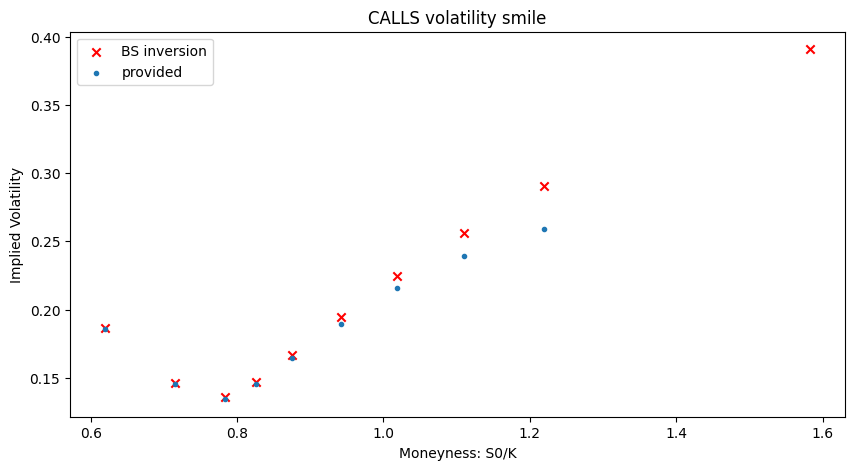

In [7]:
# Plot market implied volatilities w.r.t. log moneyness
x = (S0/calls_strikes)
# IV_filtered = [iv for iv in IV_market_p if iv != -1]
# x_filtered = [log_m for iv, log_m in zip(IV_market_p, x) if iv != -1]
IV_filtered = [iv for iv in IV_market if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market, x) if iv != -1]

fig, ax1 = plt.subplots(figsize=(10,5))

#CALLS
ax1.scatter(x, IV_market, marker='x', label='BS inversion', color='red')
ax1.scatter(x, calls['C_IV'], marker='.', label='provided')

ax1.set_xlabel('Moneyness: S0/K'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('CALLS volatility smile')

ax1.legend(); plt.show()


In [8]:
otko_spx = pd.read_csv('data/otko_spx_1year.csv')

th_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'Midpoint (%)': otko_spx['Midpoint (%)']
})
print(otko_spx)
th_mc_prices = pd.DataFrame({})
th_cf_prices = pd.DataFrame({})

otko_strikes = otko_spx[['K1', 'K2']].values / 100
otko_spreads =  otko_spx['ASK(%)'] - otko_spx['BID(%)']
otko_mkt_prices = otko_spx['Midpoint (%)'].values

  Starting date Stock Name Expiry  K1  K2  BID(%)  ASK(%)  Midpoint (%)
0    20/01/2016        SPX     1Y  75   0    0.17    0.20         0.185
1    20/01/2016        SPX     1Y  70   0    0.08    0.10         0.090
2    20/01/2016        SPX     1Y  85  75    0.34    0.40         0.370
3    20/01/2016        SPX     1Y  80  70    0.24    0.28         0.260
4    20/01/2016        SPX     1Y  90  80    0.48    0.54         0.510


 ### Calibration based on a basket of options

#### Merton Jump Diffusion model

In [10]:
x0 = mert_params     # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 0, -2, 0], [2, 2, 0, 5] )

def cost_function(x, c_strikes, c_mkt_prices, o_strikes, o_mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = np.sum( calls_spreads*(M.closed_formula_call(c_strikes) - c_mkt_prices)**2)
    for k in range(len(o_strikes)):
        sq_err +=  otko_spreads[k]*(M.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k])**2
    return sq_err

start = time.time()
mert = scpo.least_squares(cost_function, x0, args=(calls_strikes, calls_prices, otko_strikes, otko_mkt_prices), bounds=bounds, method = 'trf', verbose=2)
end = time.time()

mert_params_calibrated = [round(p,4) for p in mert.x[:4]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5681e+07                                    5.47e+07    
       1              8         2.5674e+07      7.04e+03       3.12e-04       2.62e+07    
       2              9         2.5671e+07      3.47e+03       2.79e-04       3.62e+06    
       3             10         2.5668e+07      3.01e+03       8.51e-05       3.62e+06    
       4             11         2.5662e+07      5.98e+03       1.54e-04       3.56e+06    
       5             12         2.5650e+07      1.17e+04       3.51e-04       3.61e+06    
       6             13         2.5630e+07      2.02e+04       5.40e-04       3.14e+07    
       7             16         2.5626e+07      3.80e+03       2.95e-04       5.84e+06    
       8             17         2.5624e+07      2.72e+03       1.26e-04       3.40e+06    
       9             18         2.5618e+07      5.39e+03       1.34e-04       7.36e+06    

In [11]:
print('\nMETHOD: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params_calibrated[0]} \t {round(mert_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params_calibrated[1],2))
print('> Calibrated Jump Mean = ', round(mert_params_calibrated[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params_calibrated[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


METHOD: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.1119 	 11.19%
> Calibrated Jump intensity [λ] =  0.94
> Calibrated Jump Mean =  -0.102
> Calibrated Jump St. dev.  =  0.052
TIME ELAPSED:  37.36 sec


#### Kou Jump Diffusion Model

In [12]:
x0 = kou_params     # initial guess: [σ, λ, p, η_1, η_2]
# x0 =[0.1447, 0.9, 0.7, 2.5685, 7.75]
bounds = ( [1e-3, 1e-2, 0, 0, 0], [np.inf, 5, 0.999,  15, 15] )

# Define the objective function
def cost_function(x, c_strikes, c_mkt_prices, o_strikes, o_mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=c_strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = np.sum(calls_spreads*(KOU.closed_formula_call(c_strikes) - c_mkt_prices) ** 2)
    for k in range(len(o_strikes)):
        sq_err += otko_spreads[k]*(KOU.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start2=time.time()
kou = scpo.least_squares(cost_function, x0, args=(calls_strikes, calls_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, verbose=2)
end2 =time.time()

kou_params_calibrated = [round(p,4) for p in kou.x[:5]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1216e+08                                    3.43e+09    
       1              2         1.2405e+08      8.81e+07       4.87e-01       3.18e+09    


C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:285: RuntimeWarning: overflow encountered in exp
  Y1 = np.exp((sigma * eta1) ** 2 * T / 2) / (sigma * np.sqrt(2 * np.pi * T)) * sump1
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:286: RuntimeWarning: overflow encountered in exp
  Y2 = np.exp((sigma * eta2) ** 2 * T / 2) / (sigma * np.sqrt(2 * np.pi * T)) * sumq1


       2              3         2.9034e+01      1.24e+08       8.75e+00       3.06e+02    
       3              4         4.2804e+00      2.48e+01       9.66e-01       3.93e+01    
       4              5         6.7866e-01      3.60e+00       2.36e+00       5.23e+00    
       5              6         1.0249e-01      5.76e-01       3.44e-01       8.36e-01    
       6              7         1.5646e-02      8.68e-02       2.00e-01       1.42e-01    
       7              8         2.1150e-03      1.35e-02       4.15e+00       1.95e-02    
       8              9         2.8820e-04      1.83e-03       8.68e-02       3.30e-03    
       9             10         3.2569e-05      2.56e-04       4.73e+00       4.48e-04    
      10             11         3.5974e-06      2.90e-05       3.68e-02       6.82e-05    
      11             12         3.8083e-07      3.22e-06       2.25e-02       9.33e-06    
      12             13         5.2103e-08      3.29e-07       1.44e-02       1.02e-06    

In [13]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params_calibrated[0],4)} \t {round(kou_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params_calibrated[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params_calibrated[2],2)}, [q] = {round(1-kou_params_calibrated[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params_calibrated[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params_calibrated[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 8.0572 	 805.72%
> Calibrated Jump intensity [λ] =  2.44
> Calibrated Upward Jump probability [p] = 0.93, [q] = 0.07
> Calibrated Rate of Exp. 1  [η_1] =  1.73
> Calibrated Rate of Exp. 2  [η_2] =  7.05
TIME ELAPSED:  3134.73 sec


#### Variance gamma model

In [28]:
x0 = vg_params
bounds = ( [1e-3, -3, 0], [3, 2, 10] )

def cost_function(x, c_strikes, c_mkt_prices, o_strikes, o_mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in c_strikes:
        prices.append(VG.closed_formula_call(k))
    sq_err = np.sum(calls_spreads*(prices - c_mkt_prices)**2)
    for k in range(len(o_strikes)):
        sq_err += otko_spreads[k]* (VG.closed_formula_otko5(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start3=time.time()
vg = scpo.least_squares(cost_function, x0, args=(calls_strikes, calls_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, verbose=2)
end3=time.time()

vg_params_calibrated = [round(p,4) for p in vg.x[:3]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8566e+07                                    7.96e+08    
       1              6         2.8174e+07      3.92e+05       2.07e-03       2.76e+08    
       2              7         2.8152e+07      2.25e+04       2.06e-03       4.74e+07    
       3              8         2.8138e+07      1.41e+04       3.21e-04       4.73e+07    
       4              9         2.8111e+07      2.64e+04       6.66e-04       4.69e+07    
       5             10         2.8064e+07      4.68e+04       1.43e-03       4.64e+07    
       6             11         2.7983e+07      8.12e+04       3.20e-03       4.55e+07    
       7             12         2.7826e+07      1.57e+05       6.89e-03       4.42e+07    
       8             13         2.7595e+07      2.31e+05       1.38e-02       3.92e+07    
       9             14         2.7519e+07      7.62e+04       8.21e-03       4.58e+08    

In [54]:
print('METHOD: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'TIME ELAPSED:  {round(end3-start3,2)} sec')

METHOD: LEAST-SQUARES (trf)
> Calibrated Volatility [σ] = 0.1273, 	 12.73%
> Calibrated mean rate gamma process [θ] =  0.2941
> Calibrated variance rate gamma process [v]=  0.099
TIME ELAPSED:  155.27 sec


### RESULTS FROM CALIBRATION

In [30]:
days = 252
paths = 5000


#### Merton Jump Diffusion

CALIBRATED PARAMETERS [σ		λ		m		v]
> European CALLS:	 [0.0878, 0.9085, -0.118, 0.0963]
> OTKO DC:			 [0.1116, 1.8705, -0.0162, 0.0747]
> CALLS + OTKO:		 [0.1119, 0.9357, -0.1016, 0.0524]


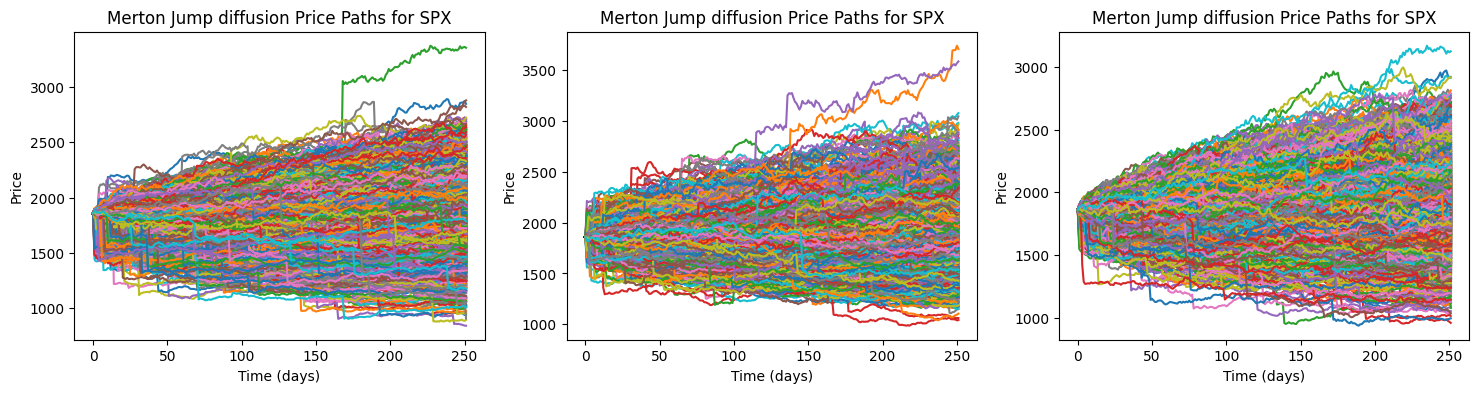

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

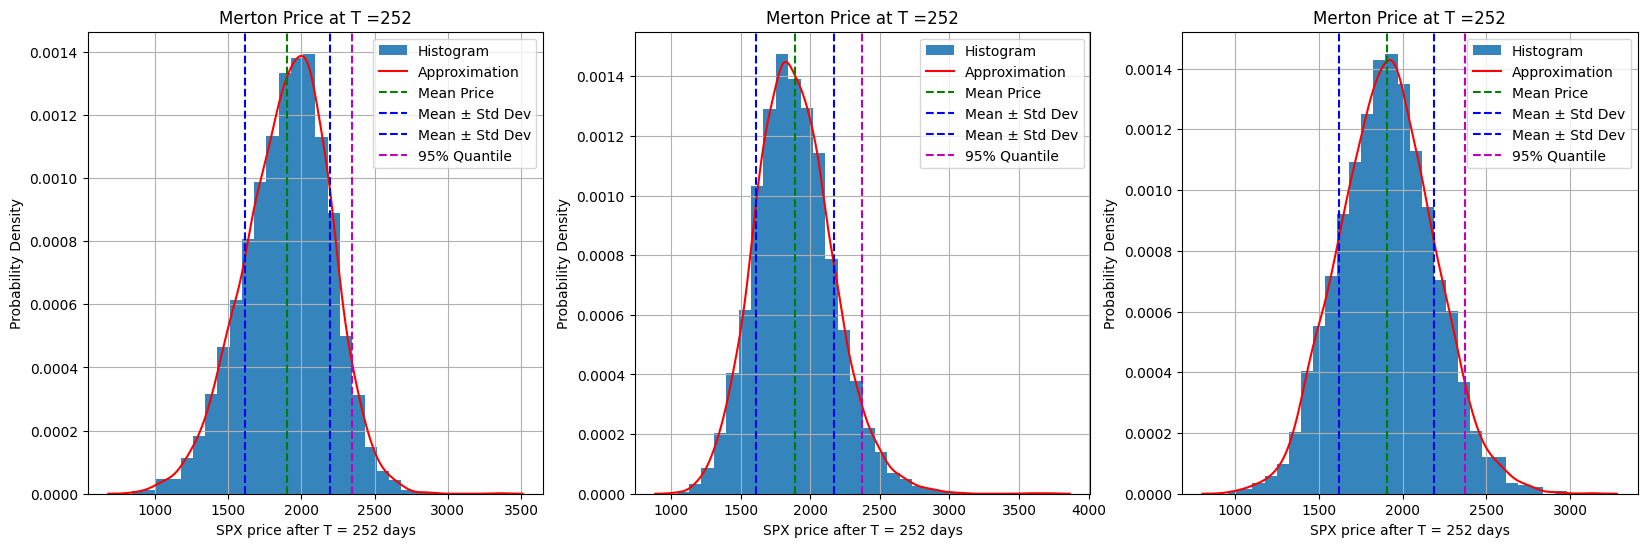

In [53]:
m_params_vanilla = [0.0878, 0.9085, -0.118, 0.0963]
m_params_otko = [0.1116, 1.8705, -0.0162, 0.0747]
m_params_basket = mert_params_calibrated

print(f'CALIBRATED PARAMETERS [σ\t\tλ\t\tm\t\tv]')
print(f'> European CALLS:\t {m_params_vanilla}')
print(f'> OTKO DC:\t\t\t {m_params_otko}')
print(f'> CALLS + OTKO:\t\t {m_params_basket}')


Merton1 = Merton_pricer(S0, None, T, r, q, m_params_vanilla[0], m_params_vanilla[1], m_params_vanilla[2], m_params_vanilla[3], exercise)
Merton2 = Merton_pricer(S0, None, T, r, q, m_params_otko[0], m_params_otko[1], m_params_otko[2], m_params_otko[3], exercise)
Merton3 = Merton_pricer(S0, None, T, r, q, m_params_basket[0], m_params_basket[1], m_params_basket[2], m_params_basket[3], exercise)

SMerton1 = Merton1.MertonPath(days, paths)
SMerton2 = Merton2.MertonPath(days, paths)
SMerton3 = Merton3.MertonPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
Merton1.plotMertonPath(SMerton1, 'SPX', ax=axes[0])
Merton2.plotMertonPath(SMerton2, 'SPX', ax=axes[1])
Merton3.plotMertonPath(SMerton3, 'SPX', ax=axes[2])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
Merton1.plotMertonAtFixedTime(SMerton1, 251, 'SPX', ax = axes[0])
Merton2.plotMertonAtFixedTime(SMerton2, 251, 'SPX', ax = axes[1])
Merton3.plotMertonAtFixedTime(SMerton3, 251, 'SPX', ax = axes[2])

Finally, we find the otko prices with the calibrated parameters.

In [41]:
# OTKO PRICES
otko_calib_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'MKT_BID (%)': otko_spx['BID(%)'],
    'MKT_MID (%)': otko_spx['Midpoint (%)'],
    'MKT_ASK (%)': otko_spx['ASK(%)']
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{otko_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)
0  75   0         0.17        0.185         0.20
1  70   0         0.08        0.090         0.10
2  85  75         0.34        0.370         0.40
3  80  70         0.24        0.260         0.28
4  90  80         0.48        0.510         0.54


Compute the otko prices for Merton Model

In [42]:
avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton3.T:
        payoffs.append(Merton3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(otko_calib_prices))
merton_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    merton_cf_prices[index] = Merton3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['MERTON MC (%)'] = merton_mc_prices
otko_calib_prices['MERTON CF (%)'] = merton_cf_prices

print(otko_calib_prices)

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)  MERTON CF (%)
0  75   0         0.17        0.185         0.20       0.000000   1.713489e-04
1  70   0         0.08        0.090         0.10       0.000000   3.624631e-07
2  85  75         0.34        0.370         0.40       0.122793   2.307084e-01
3  80  70         0.24        0.260         0.28       0.002284   1.314721e-02
4  90  80         0.48        0.510         0.54       0.954505   1.236326e+00


### Kou Jump Diffusion

CALIBRATED PARAMETERS: [σ		λ		p		η1		η2]
> European CALLS:	 [0.0932, 0.361, 0.2877, 12.5685, 3.2118]
> OTKO DC:			 [0.1447, 0.7898, 0.7847, 2.5693, 7.0148]
> CALLS + OTKO:		 [8.0572, 2.4353, 0.93, 1.7267, 7.0531]


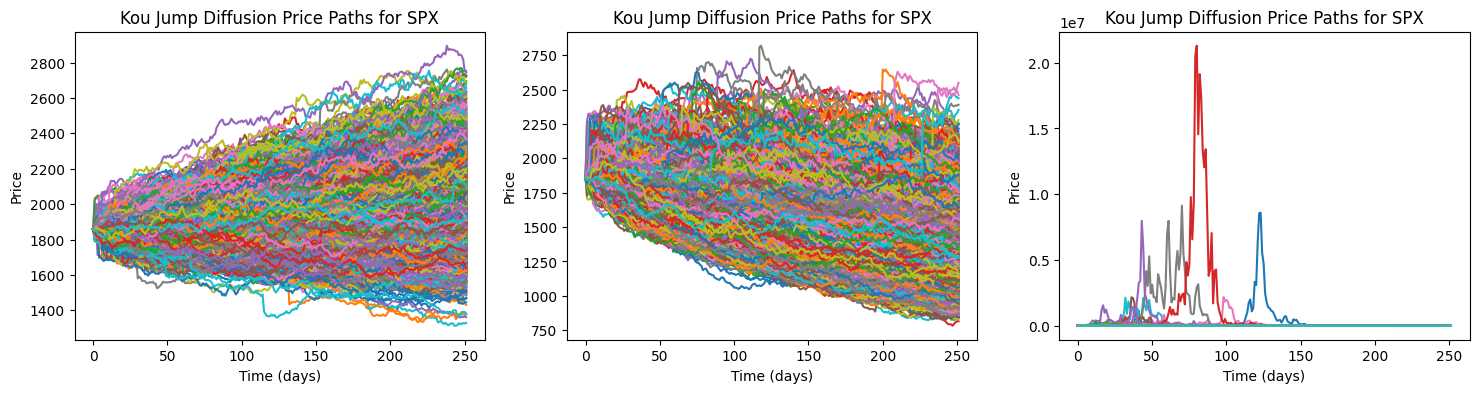

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

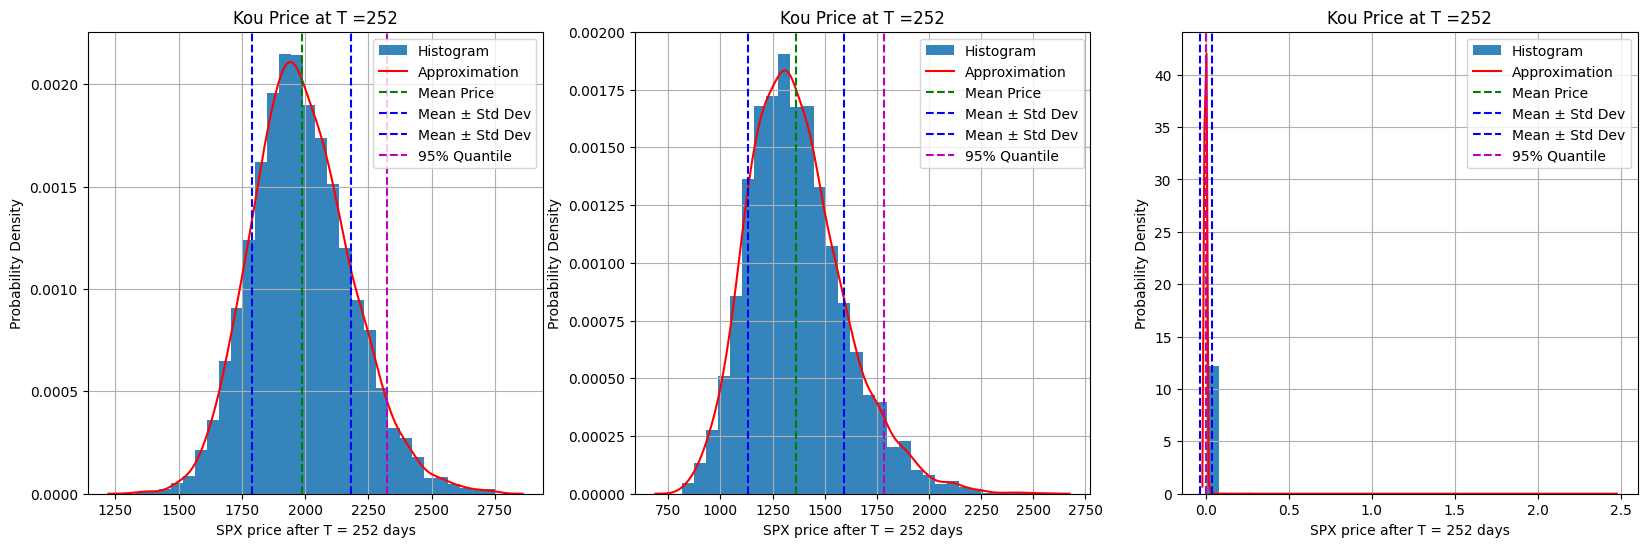

In [43]:
k_params_vanilla = [0.0932, 0.361, 0.2877, 12.5685, 3.2118]
k_params_otko = [0.1447, 0.7898, 0.7847, 2.5693, 7.0148]
k_params_basket = kou_params_calibrated

print(f'CALIBRATED PARAMETERS: [σ\t\tλ\t\tp\t\tη1\t\tη2]')
print(f'> European CALLS:\t {k_params_vanilla}')
print(f'> OTKO DC:\t\t\t {k_params_otko}')
print(f'> CALLS + OTKO:\t\t {k_params_basket}')


Kou1 = Kou_pricer(S0, None, T, r, k_params_vanilla[0], k_params_vanilla[1], k_params_vanilla[2], k_params_vanilla[3], k_params_vanilla[4], exercise)
Kou2 = Kou_pricer(S0, None, T, r, k_params_otko[0], k_params_otko[1], k_params_otko[2], k_params_otko[3], k_params_otko[4], exercise)
Kou3 = Kou_pricer(S0, None, T, r, k_params_basket[0], k_params_basket[1], k_params_basket[2], k_params_basket[3], k_params_basket[4], exercise)

SKou1 = Kou1.KouPath(days, paths)
SKou2 = Kou2.KouPath(days, paths)
SKou3 = Kou3.KouPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
Kou1.plotKouPath(SKou1, 'SPX', ax=axes[0])
Kou2.plotKouPath(SKou2, 'SPX', ax=axes[1])
Kou3.plotKouPath(SKou3, 'SPX', ax=axes[2])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
Kou1.plotKouAtFixedTime(SKou1, 251, 'SPX', ax = axes[0])
Kou2.plotKouAtFixedTime(SKou2, 251, 'SPX', ax = axes[1])
Kou3.plotKouAtFixedTime(SKou3, 251, 'SPX', ax = axes[2])

Compute the otko final prices for Kou model

In [44]:
avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou3.T:
        payoffs.append(Kou3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(otko_calib_prices))
kou_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    kou_cf_prices[index] = Kou3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['KOU MC (%)'] = kou_mc_prices
otko_calib_prices['KOU CF (%)'] = kou_cf_prices

print(otko_calib_prices)

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)   
0  75   0         0.17        0.185         0.20       0.000000  \
1  70   0         0.08        0.090         0.10       0.000000   
2  85  75         0.34        0.370         0.40       0.122793   
3  80  70         0.24        0.260         0.28       0.002284   
4  90  80         0.48        0.510         0.54       0.954505   

   MERTON CF (%)  KOU MC (%)  KOU CF (%)  
0   1.713489e-04   20.035403    0.204346  
1   3.624631e-07   18.018807    0.117742  
2   2.307084e-01    8.822621    0.350009  
3   1.314721e-02    8.653906    0.224941  
4   1.236326e+00    8.944808    0.528045  


#### Variance Gamma model

CALIBRATED PARAMETERS: [σ 		θ		 v]
> European CALLS:	 [0.151, 0.0107, 0.0909]
> OTKO DC:			 [0.1058, -0.0402, 0.6026]
> CALLS + OTKO:		 [0.1273, 0.2941, 0.099]
CALIBRATED PARAMETERS: [μ_p	 μ_n	v_p	v_n]
> European CALLS:	 [0.36, 0.349, 0.012, 0.011]
> OTKO DC:			 [0.078, 0.119, 0.004, 0.008]
> CALLS + OTKO:		 [0.469, 0.175, 0.022, 0.003]


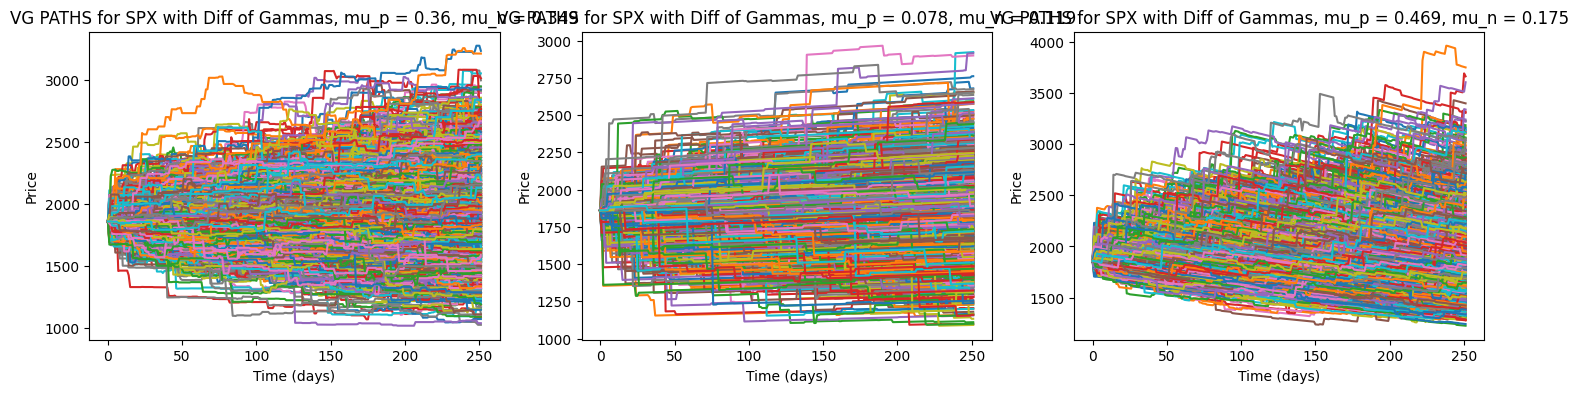

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

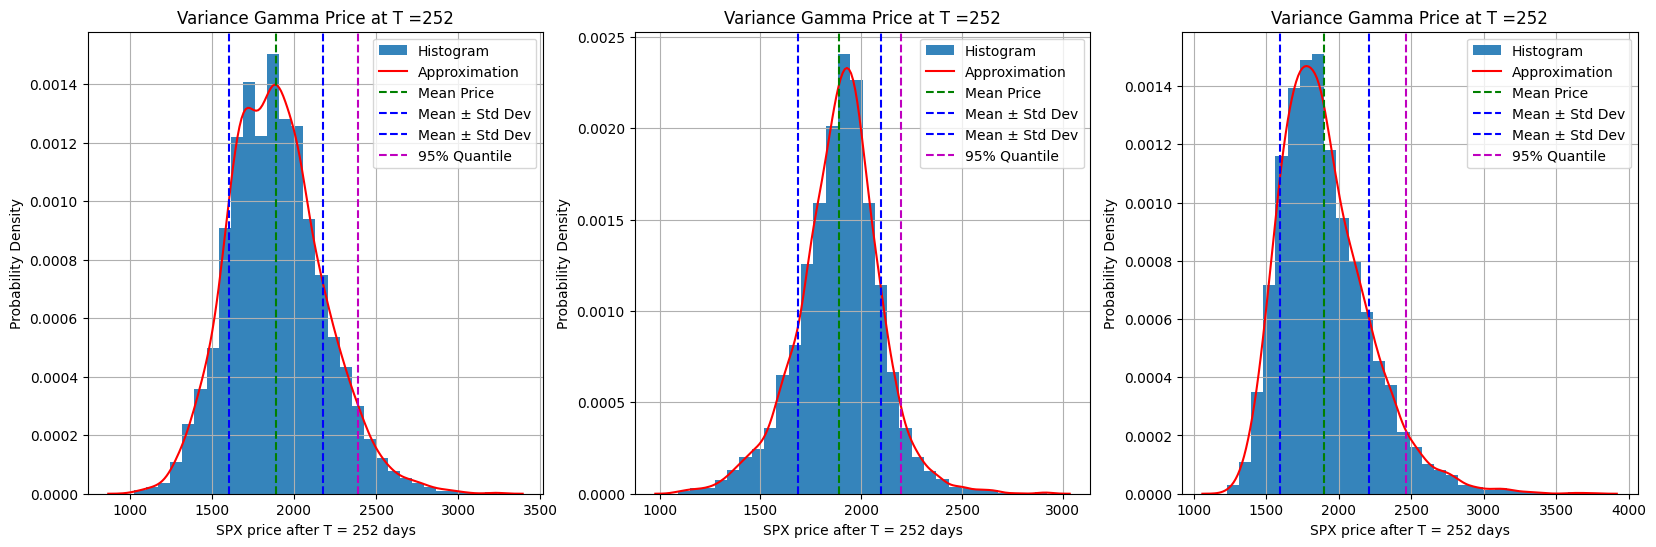

In [52]:
vg_params_vanilla = [0.151, 0.0107, 0.0909]
vg_params_otko = [0.1058, -0.0402, 0.6026]
vg_params_basket = vg_params_calibrated

print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> European CALLS:\t {vg_params_vanilla}')
print(f'> OTKO DC:\t\t\t {vg_params_otko}')
print(f'> CALLS + OTKO:\t\t {vg_params_basket}')

vg_params_vanilla2 = [0.5 * np.sqrt(vg_params_vanilla[1] ** 2 + (2 * vg_params_vanilla[0] ** 2 / vg_params_vanilla[2])) + 0.5 * vg_params_vanilla[1],
                      0.5 * np.sqrt(vg_params_vanilla[1] ** 2 + (2 * vg_params_vanilla[0] ** 2 / vg_params_vanilla[2])) - 0.5 * vg_params_vanilla[1],
                      (0.5 * np.sqrt(vg_params_vanilla[1] ** 2 + (2 * vg_params_vanilla[0] ** 2 / vg_params_vanilla[2])) + 0.5 * vg_params_vanilla[1])**2 * vg_params_vanilla[2],
                      (0.5 * np.sqrt(vg_params_vanilla[1] ** 2 + (2 * vg_params_vanilla[0] ** 2 / vg_params_vanilla[2])) - 0.5 * vg_params_vanilla[1])**2 * vg_params_vanilla[2]]

vg_params_otko2 = [0.5 * np.sqrt(vg_params_otko[1] ** 2 + (2 * vg_params_otko[0] ** 2 / vg_params_otko[2])) + 0.5 * vg_params_otko[1],
                      0.5 * np.sqrt(vg_params_otko[1] ** 2 + (2 * vg_params_otko[0] ** 2 / vg_params_otko[2])) - 0.5 * vg_params_otko[1],
                      (0.5 * np.sqrt(vg_params_otko[1] ** 2 + (2 * vg_params_otko[0] ** 2 / vg_params_otko[2])) + 0.5 * vg_params_otko[1])**2 * vg_params_otko[2],
                      (0.5 * np.sqrt(vg_params_otko[1] ** 2 + (2 * vg_params_otko[0] ** 2 / vg_params_otko[2])) - 0.5 * vg_params_otko[1])**2 * vg_params_otko[2]]
vg_params_basket2 = [0.5 * np.sqrt(vg_params_basket[1] ** 2 + (2 * vg_params_basket[0] ** 2 / vg_params_basket[2])) + 0.5 * vg_params_basket[1],
                      0.5 * np.sqrt(vg_params_basket[1] ** 2 + (2 * vg_params_basket[0] ** 2 / vg_params_basket[2])) - 0.5 * vg_params_basket[1],
                      (0.5 * np.sqrt(vg_params_basket[1] ** 2 + (2 * vg_params_basket[0] ** 2 / vg_params_basket[2])) + 0.5 * vg_params_basket[1])**2 * vg_params_basket[2],
                      (0.5 * np.sqrt(vg_params_basket[1] ** 2 + (2 * vg_params_basket[0] ** 2 / vg_params_basket[2])) - 0.5 * vg_params_basket[1])**2 * vg_params_basket[2]]

for i in range(len(vg_params_vanilla2)):
    vg_params_vanilla2[i] = round(vg_params_vanilla2[i], 3)
    vg_params_otko2[i] = round(vg_params_otko2[i], 3)
    vg_params_basket2[i] = round(vg_params_basket2[i], 3)

print(f'CALIBRATED PARAMETERS: [μ_p\t μ_n\tv_p\tv_n]')
print(f'> European CALLS:\t {vg_params_vanilla2}')
print(f'> OTKO DC:\t\t\t {vg_params_otko2}')
print(f'> CALLS + OTKO:\t\t {vg_params_basket2}')


VG1 = VG_pricer(S0, None, T, r, q, vg_params_vanilla[0], vg_params_vanilla[1], vg_params_vanilla[2],  exercise)
VG2 = VG_pricer(S0, None, T, r, q, vg_params_otko[0], vg_params_otko[1], vg_params_otko[2], exercise)
VG3 = VG_pricer(S0, None, T, r, q, vg_params_basket[0], vg_params_basket[1], vg_params_basket[2], exercise)

SVG1 = VG1.VarianceGammaPath2(days, paths)
SVG2 = VG2.VarianceGammaPath2(days, paths)
SVG3 = VG3.VarianceGammaPath2(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
VG1.plotVGPath(SVG1, 'SPX', method='Diff of Gammas', ax=axes[0])
VG2.plotVGPath(SVG2, 'SPX',method='Diff of Gammas', ax=axes[1])
VG3.plotVGPath(SVG3, 'SPX', method='Diff of Gammas', ax=axes[2])
plt.tight_layout()
plt.show()


# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
VG1.plotVGAtFixedTime(SVG1, 251, 'SPX', ax = axes[0])
VG2.plotVGAtFixedTime(SVG2, 251, 'SPX', ax = axes[1])
VG3.plotVGAtFixedTime(SVG3, 251, 'SPX', ax = axes[2])

In [46]:
avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVG3.T:
        payoffs.append(VG3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(otko_calib_prices))
vg_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    vg_cf_prices[index] = VG3.closed_formula_otko5(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['VG MC (%)'] = vg_mc_prices
otko_calib_prices['VG CF (%)'] = vg_cf_prices

In [47]:
print(otko_calib_prices)

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)   
0  75   0         0.17        0.185         0.20       0.000000  \
1  70   0         0.08        0.090         0.10       0.000000   
2  85  75         0.34        0.370         0.40       0.122793   
3  80  70         0.24        0.260         0.28       0.002284   
4  90  80         0.48        0.510         0.54       0.954505   

   MERTON CF (%)  KOU MC (%)  KOU CF (%)  VG MC (%)     VG CF (%)  
0   1.713489e-04   20.035403    0.204346    0.00000  4.075499e-08  
1   3.624631e-07   18.018807    0.117742    0.00000  5.779614e-10  
2   2.307084e-01    8.822621    0.350009    0.00000  1.062038e-04  
3   1.314721e-02    8.653906    0.224941    0.00000  2.279593e-06  
4   1.236326e+00    8.944808    0.528045    0.00606  4.371332e-03  
